In [50]:
#@title run in case colab is stupid
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Required Files

To run this fully, you need to upload data.zip, 100000.jpg, and norm_bounding_boxes.csv, which can be found in the following folder:

https://drive.google.com/drive/u/0/folders/1pX8dp1FtKQAG2U2XQFesemyJIwuCvGdT

There are also a bunch of saved models that can be uploaded and run here with torch.load(path_to_model).

# Upload Data

Upload a zip file data.zip and a singular jpeg. data.zip should have 9999 images called (000001.jpg, ..., 009999.jpg) from CelebA. There's an extra 10000th image because Windows only allows 9999 files max. When unzipped, images should be in a folder called data.

In [1]:
%%capture
!unzip data.zip

In [2]:
!mv 010000.jpg data/010000.jpg

# Dataset

Upload norm_bounding_boxes.csv, which contains the coordinates of the bounding boxes for all images. Code for generating the bounding box is not in this notebook unfortunately.

In [26]:
#@title FaceDataset initialize
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np

class FaceDataset(Dataset):
    def __init__(self, df_path, image_dir):
        self.dataframe = pd.read_csv(df_path)
        self.image_dir = image_dir

        # Transformations
        self.transform = transforms.Compose([
            transforms.Resize((92, 84)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        bbox = self.dataframe.iloc[idx, 1:5].values
        face_crop = image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))


        if self.transform:
            face_crop = self.transform(face_crop)

        to_tensor = transforms.ToTensor()
        image = to_tensor(image)

        bbox = np.array(bbox, dtype=int)

        return image, face_crop, torch.tensor(bbox)


if __name__ == "__main__":
    # Load the bounding box data
    df_path = 'norm_bounding_boxes.csv'

    # Initialize dataset and dataloader
    dataset = FaceDataset(df_path, 'data')
    dataloader = DataLoader(dataset, batch_size=25, shuffle=False)

In [27]:
#@title Model initialize
import torch
import torch.nn as nn

# Unused
class SoftRound(nn.Module):
    def __init__(self):
        super().__init__()

    def round(self, x):
        return x - torch.sin(2 * torch.pi * x) / (3 * torch.pi)

    def forward(self, x):
        x = self.round(x * 255)
        x = self.round(x)
        x = self.round(x)
        return x

class FGAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(FGAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Maintains 92x84
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 46x42
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Maintains 46x42
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 23x21
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Maintains 23x21
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 11x10
            nn.Flatten(),
            nn.Linear(64 * 11 * 10, latent_dim),
            nn.ReLU()
            # nn.Sigmoid(),
            # SoftRound()
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 11 * 10),
            nn.ReLU(),
            nn.Unflatten(1, (64, 11, 10)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Outputs 23x21
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, output_padding=1),  # Outputs 46x42
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # Outputs 92x84
            nn.Sigmoid()  # Ensures output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

class BGAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(BGAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Maintains 218x178
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 109x89
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Maintains 109x89
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 54x44
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Maintains 54x44
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 27x22
            nn.Flatten(),
            nn.Linear(64 * 27 * 22, latent_dim),
            nn.ReLU()
            # nn.Sigmoid(),
            # SoftRound()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 27 * 22),
            nn.ReLU(),
            nn.Unflatten(1, (64, 27, 22)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Outputs 54x44
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Outputs 109x89
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=0),  # Outputs 218x178
            nn.Sigmoid()  # Ensures output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class TwoResAutoEncoder(nn.Module):
    def __init__(self, high_latent_dim, low_latent_dim):
        super(TwoResAutoEncoder, self).__init__()
        self.fg_ae = FGAutoencoder(high_latent_dim)
        self.bg_ae = BGAutoencoder(low_latent_dim)

    def forward(self, image, face):
        fg_output = self.fg_ae(face)
        bg_output = self.bg_ae(image)

        return fg_output, bg_output

In [28]:
#@title MS-SSIM initialize
#@markdown Adapted from https://github.com/VainF/pytorch-msssim

import warnings
from typing import List, Optional, Tuple, Union

import torch
import torch.nn.functional as F
from torch import Tensor


def _fspecial_gauss_1d(size: int, sigma: float) -> Tensor:
    r"""Create 1-D gauss kernel
    Args:
        size (int): the size of gauss kernel
        sigma (float): sigma of normal distribution
    Returns:
        torch.Tensor: 1D kernel (1 x 1 x size)
    """
    coords = torch.arange(size, dtype=torch.float)
    coords -= size // 2

    g = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
    g /= g.sum()

    return g.unsqueeze(0).unsqueeze(0)


def gaussian_filter(input: Tensor, win: Tensor) -> Tensor:
    r""" Blur input with 1-D kernel
    Args:
        input (torch.Tensor): a batch of tensors to be blurred
        window (torch.Tensor): 1-D gauss kernel
    Returns:
        torch.Tensor: blurred tensors
    """
    assert all([ws == 1 for ws in win.shape[1:-1]]), win.shape
    if len(input.shape) == 4:
        conv = F.conv2d
    elif len(input.shape) == 5:
        conv = F.conv3d
    else:
        raise NotImplementedError(input.shape)

    C = input.shape[1]
    out = input
    for i, s in enumerate(input.shape[2:]):
        if s >= win.shape[-1]:
            out = conv(out, weight=win.transpose(2 + i, -1), stride=1, padding=0, groups=C)
        else:
            warnings.warn(
                f"Skipping Gaussian Smoothing at dimension 2+{i} for input: {input.shape} and win size: {win.shape[-1]}"
            )

    return out


def _ssim(
    X: Tensor,
    Y: Tensor,
    data_range: float,
    win: Tensor,
    size_average: bool = True,
    K: Union[Tuple[float, float], List[float]] = (0.01, 0.03),
    mask: Tensor = None
) -> Tuple[Tensor, Tensor]:
    r""" Calculate ssim index for X and Y

    Args:
        X (torch.Tensor): images
        Y (torch.Tensor): images
        data_range (float or int): value range of input images. (usually 1.0 or 255)
        win (torch.Tensor): 1-D gauss kernel
        size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: ssim results.
    """
    K1, K2 = K
    # batch, channel, [depth,] height, width = X.shape
    compensation = 1.0

    C1 = (K1 * data_range) ** 2
    C2 = (K2 * data_range) ** 2

    win = win.to(X.device, dtype=X.dtype)

    mu1 = gaussian_filter(X, win)
    mu2 = gaussian_filter(Y, win)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = compensation * (gaussian_filter(X * X, win) - mu1_sq)
    sigma2_sq = compensation * (gaussian_filter(Y * Y, win) - mu2_sq)
    sigma12 = compensation * (gaussian_filter(X * Y, win) - mu1_mu2)

    cs_map = (2 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)  # set alpha=beta=gamma=1

    if mask is not None:
        resizing = Resize(cs_map.shape[-2:])
        weights = resizing(mask).to(device).float()
        cs_map = 2 * (((cs_map + 1) / 2) ** weights) - 1

    ssim_map = ((2 * mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1)) * cs_map

    ssim_per_channel = torch.flatten(ssim_map, 2).mean(-1)
    cs = torch.flatten(cs_map, 2).mean(-1)
    return ssim_per_channel, cs


def ms_ssim(
    X: Tensor,
    Y: Tensor,
    data_range: float = 255,
    size_average: bool = True,
    win_size: int = 11,
    win_sigma: float = 1.5,
    win: Optional[Tensor] = None,
    weights: Optional[List[float]] = None,
    K: Union[Tuple[float, float], List[float]] = (0.01, 0.03),
    mask: Tensor = None
) -> Tensor:
    r""" interface of ms-ssim
    Args:
        X (torch.Tensor): a batch of images, (N,C,[T,]H,W)
        Y (torch.Tensor): a batch of images, (N,C,[T,]H,W)
        data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
        size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar
        win_size: (int, optional): the size of gauss kernel
        win_sigma: (float, optional): sigma of normal distribution
        win (torch.Tensor, optional): 1-D gauss kernel. if None, a new kernel will be created according to win_size and win_sigma
        weights (list, optional): weights for different levels
        K (list or tuple, optional): scalar constants (K1, K2). Try a larger K2 constant (e.g. 0.4) if you get a negative or NaN results.
    Returns:
        torch.Tensor: ms-ssim results
    """
    if not X.shape == Y.shape:
        raise ValueError(f"Input images should have the same dimensions, but got {X.shape} and {Y.shape}.")

    for d in range(len(X.shape) - 1, 1, -1):
        X = X.squeeze(dim=d)
        Y = Y.squeeze(dim=d)

    #if not X.type() == Y.type():
    #    raise ValueError(f"Input images should have the same dtype, but got {X.type()} and {Y.type()}.")

    if len(X.shape) == 4:
        avg_pool = F.avg_pool2d
    elif len(X.shape) == 5:
        avg_pool = F.avg_pool3d
    else:
        raise ValueError(f"Input images should be 4-d or 5-d tensors, but got {X.shape}")

    if win is not None:  # set win_size
        win_size = win.shape[-1]

    if not (win_size % 2 == 1):
        raise ValueError("Window size should be odd.")

    smaller_side = min(X.shape[-2:])
    assert smaller_side > (win_size - 1) * (
        2 ** 4
    ), "Image size should be larger than %d due to the 4 downsamplings in ms-ssim" % ((win_size - 1) * (2 ** 4))

    if weights is None:
        weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
    weights_tensor = X.new_tensor(weights)

    if win is None:
        win = _fspecial_gauss_1d(win_size, win_sigma)
        win = win.repeat([X.shape[1]] + [1] * (len(X.shape) - 1))

    levels = weights_tensor.shape[0]
    mcs = []
    for i in range(levels):
        ssim_per_channel, cs = _ssim(X, Y, win=win, data_range=data_range, size_average=False, K=K, mask=mask)
        mask = None

        if i < levels - 1:
            mcs.append(torch.relu(cs))
            padding = [s % 2 for s in X.shape[2:]]
            X = avg_pool(X, kernel_size=2, padding=padding)
            Y = avg_pool(Y, kernel_size=2, padding=padding)

    ssim_per_channel = torch.relu(ssim_per_channel)  # type: ignore  # (batch, channel)
    mcs_and_ssim = torch.stack(mcs + [ssim_per_channel], dim=0)  # (level, batch, channel)
    ms_ssim_val = torch.prod(mcs_and_ssim ** weights_tensor.view(-1, 1, 1), dim=0)

    if size_average:
        return ms_ssim_val.mean()
    else:
        return ms_ssim_val.mean(1)

class MS_SSIM(torch.nn.Module):
    def __init__(
        self,
        data_range: float = 255,
        size_average: bool = True,
        win_size: int = 11,
        win_sigma: float = 1.5,
        channel: int = 3,
        spatial_dims: int = 2,
        weights: Optional[List[float]] = None,
        K: Union[Tuple[float, float], List[float]] = (0.01, 0.03),
    ) -> None:
        r""" class for ms-ssim
        Args:
            data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
            size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar
            win_size: (int, optional): the size of gauss kernel
            win_sigma: (float, optional): sigma of normal distribution
            channel (int, optional): input channels (default: 3)
            weights (list, optional): weights for different levels
            K (list or tuple, optional): scalar constants (K1, K2). Try a larger K2 constant (e.g. 0.4) if you get a negative or NaN results.
        """

        super(MS_SSIM, self).__init__()
        self.win_size = win_size
        self.win = _fspecial_gauss_1d(win_size, win_sigma).repeat([channel, 1] + [1] * spatial_dims)
        self.size_average = size_average
        self.data_range = data_range
        self.weights = weights
        self.K = K

    def forward(self, X: Tensor, Y: Tensor, mask: Tensor = None) -> Tensor:
        return ms_ssim(
            X,
            Y,
            data_range=self.data_range,
            size_average=self.size_average,
            win=self.win,
            weights=self.weights,
            K=self.K,
            mask=mask
        )

In [29]:
#@title LPIPS initialize
#@markdown Adapted from https://github.com/richzhang/PerceptualSimilarity
%%capture
!git clone https://github.com/richzhang/PerceptualSimilarity
!mv PerceptualSimilarity/lpips/weights weights
!rm -rf PerceptualSimilarity

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import numpy as np
from collections import namedtuple
from torchvision import models as tv

# def psnr(p0, p1, peak=255.):
#     return 10*np.log10(peak**2/np.mean((1.*p0-1.*p1)**2))

def psnr(p0, p1, peak=255.):
    return 10 * torch.log10(peak ** 2 / torch.mean((p0 - p1) ** 2))


def normalize_tensor(in_feat,eps=1e-10):
    norm_factor = torch.sqrt(torch.sum(in_feat**2,dim=1,keepdim=True))
    return in_feat/(norm_factor+eps)

def l2(p0, p1, range=255.):
    return .5*np.mean((p0 / range - p1 / range)**2)


def tensor2np(tensor_obj):
    # change dimension of a tensor object into a numpy array
    return tensor_obj[0].cpu().float().numpy().transpose((1,2,0))

def np2tensor(np_obj):
     # change dimenion of np array into tensor array
    return torch.Tensor(np_obj[:, :, :, np.newaxis].transpose((3, 2, 0, 1)))

def tensor2tensorlab(image_tensor,to_norm=True,mc_only=False):
    # image tensor to lab tensor
    from skimage import color

    img = tensor2im(image_tensor)
    img_lab = color.rgb2lab(img)
    if(mc_only):
        img_lab[:,:,0] = img_lab[:,:,0]-50
    if(to_norm and not mc_only):
        img_lab[:,:,0] = img_lab[:,:,0]-50
        img_lab = img_lab/100.

    return np2tensor(img_lab)


def tensor2im(image_tensor, imtype=np.uint8, cent=1., factor=255./2.):
    image_numpy = image_tensor[0].cpu().float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + cent) * factor
    return image_numpy.astype(imtype)


class squeezenet(torch.nn.Module):
    def __init__(self, requires_grad=False, pretrained=True):
        super(squeezenet, self).__init__()
        pretrained_features = tv.squeezenet1_1(pretrained=pretrained).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.slice6 = torch.nn.Sequential()
        self.slice7 = torch.nn.Sequential()
        self.N_slices = 7
        for x in range(2):
            self.slice1.add_module(str(x), pretrained_features[x])
        for x in range(2,5):
            self.slice2.add_module(str(x), pretrained_features[x])
        for x in range(5, 8):
            self.slice3.add_module(str(x), pretrained_features[x])
        for x in range(8, 10):
            self.slice4.add_module(str(x), pretrained_features[x])
        for x in range(10, 11):
            self.slice5.add_module(str(x), pretrained_features[x])
        for x in range(11, 12):
            self.slice6.add_module(str(x), pretrained_features[x])
        for x in range(12, 13):
            self.slice7.add_module(str(x), pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        h = self.slice6(h)
        h_relu6 = h
        h = self.slice7(h)
        h_relu7 = h
        vgg_outputs = namedtuple("SqueezeOutputs", ['relu1','relu2','relu3','relu4','relu5','relu6','relu7'])
        out = vgg_outputs(h_relu1,h_relu2,h_relu3,h_relu4,h_relu5,h_relu6,h_relu7)

        return out


class alexnet(torch.nn.Module):
    def __init__(self, requires_grad=False, pretrained=True):
        super(alexnet, self).__init__()
        alexnet_pretrained_features = tv.alexnet(pretrained=pretrained).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.N_slices = 5
        for x in range(2):
            self.slice1.add_module(str(x), alexnet_pretrained_features[x])
        for x in range(2, 5):
            self.slice2.add_module(str(x), alexnet_pretrained_features[x])
        for x in range(5, 8):
            self.slice3.add_module(str(x), alexnet_pretrained_features[x])
        for x in range(8, 10):
            self.slice4.add_module(str(x), alexnet_pretrained_features[x])
        for x in range(10, 12):
            self.slice5.add_module(str(x), alexnet_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        alexnet_outputs = namedtuple("AlexnetOutputs", ['relu1', 'relu2', 'relu3', 'relu4', 'relu5'])
        out = alexnet_outputs(h_relu1, h_relu2, h_relu3, h_relu4, h_relu5)

        return out

class vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False, pretrained=True):
        super(vgg16, self).__init__()
        vgg_pretrained_features = tv.vgg16(pretrained=pretrained).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.N_slices = 5
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(23, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        h = self.slice5(h)
        h_relu5_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3, h_relu5_3)

        return out



class resnet(torch.nn.Module):
    def __init__(self, requires_grad=False, pretrained=True, num=18):
        super(resnet, self).__init__()
        if(num==18):
            self.net = tv.resnet18(pretrained=pretrained)
        elif(num==34):
            self.net = tv.resnet34(pretrained=pretrained)
        elif(num==50):
            self.net = tv.resnet50(pretrained=pretrained)
        elif(num==101):
            self.net = tv.resnet101(pretrained=pretrained)
        elif(num==152):
            self.net = tv.resnet152(pretrained=pretrained)
        self.N_slices = 5

        self.conv1 = self.net.conv1
        self.bn1 = self.net.bn1
        self.relu = self.net.relu
        self.maxpool = self.net.maxpool
        self.layer1 = self.net.layer1
        self.layer2 = self.net.layer2
        self.layer3 = self.net.layer3
        self.layer4 = self.net.layer4

    def forward(self, X):
        h = self.conv1(X)
        h = self.bn1(h)
        h = self.relu(h)
        h_relu1 = h
        h = self.maxpool(h)
        h = self.layer1(h)
        h_conv2 = h
        h = self.layer2(h)
        h_conv3 = h
        h = self.layer3(h)
        h_conv4 = h
        h = self.layer4(h)
        h_conv5 = h

        outputs = namedtuple("Outputs", ['relu1','conv2','conv3','conv4','conv5'])
        out = outputs(h_relu1, h_conv2, h_conv3, h_conv4, h_conv5)

        return out

def upsample(in_tens, out_HW=(64,64)): # assumes scale factor is same for H and W
    in_H, in_W = in_tens.shape[2], in_tens.shape[3]
    return nn.Upsample(size=out_HW, mode='bilinear', align_corners=False)(in_tens)

# Learned perceptual metric
class LPIPS(nn.Module):
    def __init__(self, pretrained=True, net='squeeze', version='0.1', lpips=True, spatial=False,
        pnet_rand=False, pnet_tune=False, use_dropout=True, model_path=None, eval_mode=True, verbose=True):
        """ Initializes a perceptual loss torch.nn.Module

        Parameters (default listed first)
        ---------------------------------
        lpips : bool
            [True] use linear layers on top of base/trunk network
            [False] means no linear layers; each layer is averaged together
        pretrained : bool
            This flag controls the linear layers, which are only in effect when lpips=True above
            [True] means linear layers are calibrated with human perceptual judgments
            [False] means linear layers are randomly initialized
        pnet_rand : bool
            [False] means trunk loaded with ImageNet classification weights
            [True] means randomly initialized trunk
        net : str
            ['alex','vgg','squeeze'] are the base/trunk networks available
        version : str
            ['v0.1'] is the default and latest
            ['v0.0'] contained a normalization bug; corresponds to old arxiv v1 (https://arxiv.org/abs/1801.03924v1)
        model_path : 'str'
            [None] is default and loads the pretrained weights from paper https://arxiv.org/abs/1801.03924v1

        The following parameters should only be changed if training the network

        eval_mode : bool
            [True] is for test mode (default)
            [False] is for training mode
        pnet_tune
            [False] keep base/trunk frozen
            [True] tune the base/trunk network
        use_dropout : bool
            [True] to use dropout when training linear layers
            [False] for no dropout when training linear layers
        """

        super(LPIPS, self).__init__()
        if(verbose):
            print('Setting up [%s] perceptual loss: trunk [%s], v[%s], spatial [%s]'%
                ('LPIPS' if lpips else 'baseline', net, version, 'on' if spatial else 'off'))

        self.pnet_type = net
        self.pnet_tune = pnet_tune
        self.pnet_rand = pnet_rand
        self.spatial = spatial
        self.lpips = lpips # false means baseline of just averaging all layers
        self.version = version
        self.scaling_layer = ScalingLayer()

        if(self.pnet_type in ['vgg','vgg16']):
            net_type = vgg16
            self.chns = [64,128,256,512,512]
        elif(self.pnet_type=='alex'):
            net_type = alexnet
            self.chns = [64,192,384,256,256]
        elif(self.pnet_type=='squeeze'):
            net_type = squeezenet
            self.chns = [64,128,256,384,384,512,512]
        self.L = len(self.chns)

        self.net = net_type(pretrained=not self.pnet_rand, requires_grad=self.pnet_tune)

        if(lpips):
            self.lin0 = NetLinLayer(self.chns[0], use_dropout=use_dropout)
            self.lin1 = NetLinLayer(self.chns[1], use_dropout=use_dropout)
            self.lin2 = NetLinLayer(self.chns[2], use_dropout=use_dropout)
            self.lin3 = NetLinLayer(self.chns[3], use_dropout=use_dropout)
            self.lin4 = NetLinLayer(self.chns[4], use_dropout=use_dropout)
            self.lins = [self.lin0,self.lin1,self.lin2,self.lin3,self.lin4]
            if(self.pnet_type=='squeeze'): # 7 layers for squeezenet
                self.lin5 = NetLinLayer(self.chns[5], use_dropout=use_dropout)
                self.lin6 = NetLinLayer(self.chns[6], use_dropout=use_dropout)
                self.lins+=[self.lin5,self.lin6]
            self.lins = nn.ModuleList(self.lins)

            if(pretrained):
                if(model_path is None):
                    import inspect
                    import os
                    model_path = os.path.abspath(os.path.join(inspect.getfile(self.__init__), '..', 'weights/v%s/%s.pth'%(version,net)))

                if(verbose):
                    print('Loading model from: %s'%model_path)
                self.load_state_dict(torch.load(model_path, map_location='cpu'), strict=False)

        if(eval_mode):
            self.eval()

    def forward(self, in0, in1, retPerLayer=False, normalize=False, mask=None):
        return lpips_forward(self, in0, in1, retPerLayer, normalize, mask)

class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer('shift', torch.Tensor([-.030,-.088,-.188])[None,:,None,None])
        self.register_buffer('scale', torch.Tensor([.458,.448,.450])[None,:,None,None])

    def forward(self, inp):
        return (inp - self.shift) / self.scale


class NetLinLayer(nn.Module):
    ''' A single linear layer which does a 1x1 conv '''
    def __init__(self, chn_in, chn_out=1, use_dropout=False):
        super(NetLinLayer, self).__init__()

        layers = [nn.Dropout(),] if(use_dropout) else []
        layers += [nn.Conv2d(chn_in, chn_out, 1, stride=1, padding=0, bias=False),]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class Dist2LogitLayer(nn.Module):
    ''' takes 2 distances, puts through fc layers, spits out value between [0,1] (if use_sigmoid is True) '''
    def __init__(self, chn_mid=32, use_sigmoid=True):
        super(Dist2LogitLayer, self).__init__()

        layers = [nn.Conv2d(5, chn_mid, 1, stride=1, padding=0, bias=True),]
        layers += [nn.LeakyReLU(0.2,True),]
        layers += [nn.Conv2d(chn_mid, chn_mid, 1, stride=1, padding=0, bias=True),]
        layers += [nn.LeakyReLU(0.2,True),]
        layers += [nn.Conv2d(chn_mid, 1, 1, stride=1, padding=0, bias=True),]
        if(use_sigmoid):
            layers += [nn.Sigmoid(),]
        self.model = nn.Sequential(*layers)

    def forward(self,d0,d1,eps=0.1):
        return self.model.forward(torch.cat((d0,d1,d0-d1,d0/(d1+eps),d1/(d0+eps)),dim=1))

class BCERankingLoss(nn.Module):
    def __init__(self, chn_mid=32):
        super(BCERankingLoss, self).__init__()
        self.net = Dist2LogitLayer(chn_mid=chn_mid)
        # self.parameters = list(self.net.parameters())
        self.loss = torch.nn.BCELoss()

    def forward(self, d0, d1, judge):
        per = (judge+1.)/2.
        self.logit = self.net.forward(d0,d1)
        return self.loss(self.logit, per)


def spatial_average(in_tens, keepdim=True, mask=None):
    if mask is not None:
        resizing = Resize((in_tens.shape[2], in_tens.shape[3]))
        resized_mask = resizing(mask)

        # fig, ax = plt.subplots(1, 3)
        # fig.set_figwidth(15)
        # fig.set_figheight(7)

        # img = ax[0].imshow(in_tens[0, 0].cpu().detach())
        # fig.colorbar(img)
        # img = ax[1].imshow(resized_mask[0, 0].cpu().detach())
        # fig.colorbar(img)

        in_tens = resized_mask * in_tens
        # img = ax[2].imshow(in_tens[0, 0].cpu().detach())
        # fig.colorbar(img)
        # fig.show()
        return torch.sum(in_tens, dim=(2, 3), keepdim=keepdim) / torch.sum(resized_mask, dim=(2, 3))

    return in_tens.mean([2,3],keepdim=keepdim)

def lpips_forward(self, in0, in1, retPerLayer=False, normalize=False, mask=None):
    if normalize: # turn on this flag if input is [0,1] so it can be adjusted to [-1, +1]
        in0 = 2 * in0  - 1
        in1 = 2 * in1  - 1

    # v0.0 - original release had a bug, where input was not scaled
    in0_input, in1_input = (self.scaling_layer(in0), self.scaling_layer(in1)) if self.version=='0.1' else (in0, in1)
    outs0, outs1 = self.net.forward(in0_input), self.net.forward(in1_input)
    feats0, feats1, diffs = {}, {}, {}

    for kk in range(self.L):
        feats0[kk], feats1[kk] = normalize_tensor(outs0[kk]), normalize_tensor(outs1[kk])
        diffs[kk] = (feats0[kk] - feats1[kk]) ** 2

    if(self.lpips):
        if(self.spatial):
            res = [upsample(self.lins[kk](diffs[kk]), out_HW=in0.shape[2:]) for kk in range(self.L)]
        else:
            res = [spatial_average(self.lins[kk](diffs[kk]), keepdim=True, mask=mask) for kk in range(self.L)]
    else:
        if(self.spatial):
            res = [upsample(diffs[kk].sum(dim=1,keepdim=True), out_HW=in0.shape[2:]) for kk in range(self.L)]
        else:
            res = [spatial_average(diffs[kk].sum(dim=1,keepdim=True), keepdim=True, mask=mask) for kk in range(self.L)]

    val = 0
    for l in range(self.L):
        val += res[l]

    if(retPerLayer):
        return (val, res)
    else:
        return val


In [7]:
from torchvision.transforms import Resize
device = "cuda" if torch.cuda.is_available() else "cpu"

lpips_alex = LPIPS(net='alex').to(device)
lpips_squeeze = LPIPS(net='squeeze').to(device)
lpips_vgg = LPIPS(net='vgg').to(device)

ms_ssim_loss = MS_SSIM(data_range=1, size_average=True, channel=3)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 121MB/s]


Loading model from: /content/weights/v0.1/alex.pth


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]


100%|██████████| 4.73M/4.73M [00:00<00:00, 32.2MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /content/weights/v0.1/squeeze.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 111MB/s] 


Loading model from: /content/weights/v0.1/vgg.pth


In [35]:
#@title Model training + Loss functions. Contains commented code based on model used (baseline vs. 2 autoencoders)

import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Subset
import sys

def create_fg_masks(bboxes, image_height=218, image_width=178):
    """
    Create foreground masks for a batch of images given their bounding boxes, vectorized version.
    """
    batch_size = bboxes.size(0)
    # Create coordinate grids
    x_coords = torch.arange(image_width).repeat(image_height, 1).unsqueeze(0).repeat(batch_size, 1, 1)
    y_coords = torch.arange(image_height).repeat(image_width, 1).t().unsqueeze(0).repeat(batch_size, 1, 1)

    # Get bbox coordinates and expand dimensions for broadcasting
    lefts = bboxes[:, 0].unsqueeze(1).unsqueeze(2)
    tops = bboxes[:, 1].unsqueeze(1).unsqueeze(2)
    rights = bboxes[:, 2].unsqueeze(1).unsqueeze(2)
    bottoms = bboxes[:, 3].unsqueeze(1).unsqueeze(2)

    # Create masks using logical operations
    masks = (x_coords >= lefts) & (x_coords < rights) & (y_coords >= tops) & (y_coords < bottoms)
    masks = masks.float().unsqueeze(1)  # Convert from bool to float and add channel dimension

    return masks >= 1


#!!!!!!!!! custom loss functions
def fg_criterion(recon, img) -> None:
    # gamma_mask = torch.mean(img, dim=1, keepdim=True)
    # l1_loss = torch.mean(gamma_mask * torch.abs(img - recon))
    l1_loss = torch.mean(torch.abs(img - recon))
    # loss_lpips = torch.mean(lpips_alex(2 * img - 1, 2 * recon - 1, mask=gamma_mask))

    if recon.shape[-2] <= 160 or recon.shape[-1] <= 160:
        h, w = recon.shape[-2], recon.shape[-1]
        if w <= 160:
            resizing = Resize((round(161 * h / w), 161))
        elif h <= 160:
            resizing = Resize((161, round(161 * w / h)))
        recon, img = resizing(recon), resizing(img)
    loss_ms_ssim = 1 - ms_ssim_loss(img, recon)
    return 5 * l1_loss + loss_ms_ssim

def bg_criterion(recon, img, mask) -> None:
    l1_loss = torch.mean(mask * torch.abs(img * mask - recon * mask))
    # loss_lpips = torch.mean(lpips_alex(2 * img - 1, 2 * recon - 1, mask=gamma_mask))

    loss_ms_ssim = 1 - ms_ssim_loss(img * mask, recon * mask)
    return 5 * l1_loss + loss_ms_ssim

# def bg_criterion(recon, img, mask) -> None:
#     gamma_mask = torch.mean(img, dim=1, keepdim=True)
#     return gamma_mask * (img - recon) ** 2



def train():
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # model = TwoResAutoEncoder(250, 750)
    model = BGAutoencoder(1000)

    # model = torch.load('boiNet_good_10000v2.pt')
    model.to(torch.device(device))
    model.train()

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Initialize dataset and dataloader
    full_dataset = FaceDataset('norm_bounding_boxes.csv', 'data')

    #!!!!!!!!!!!!!! default loss functions
    # bg_criterion = nn.MSELoss(reduction='none')
    # fg_criterion = nn.MSELoss()

    num_epochs = 10
    batch_size = 25
    dataset_size = len(full_dataset)
    model_save_name = "l2,baseline,mask.pt"


    # Create a subset of the full dataset (100 samples)
    # indices = np.random.permutation(len(full_dataset))[:100]
    indices = list(range(dataset_size))
    dataset = Subset(full_dataset, indices)

    # dataset = FaceDataset('norm_bounding_boxes.csv', '../celeba/img_align_celeba')
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        total_fg_loss = 0.0
        total_bg_loss = 0.0
        for i, (images, faces, bboxs) in enumerate(dataloader):

            # Forward pass
            images = images.to(device)
            faces = faces.to(device)

            fg_masks = create_fg_masks(bboxs)
            fg_masks = fg_masks.to(device)

            optimizer.zero_grad()

            # Base model
            output = model(images)
            loss = torch.mean(bg_criterion(images, output))

            # fg_output, bg_output = model(images * (~fg_masks), faces)

            #!!!!!!!!!!!!!Custom loss function
            fg_loss = fg_criterion(fg_output, faces)
            bg_loss = bg_criterion(bg_output, images, ~fg_masks)

            #!!!!!!!!!!!!!!Default loss function
            # fg_loss = fg_criterion(fg_output, faces)
            # bg_loss = fg_criterion(bg_output, images)
            # bg_loss = bg_loss.sum() / (~fg_masks).sum()

            # print(fg_loss, bg_loss)

            # Combine losses and perform backpropagation
            total_loss = fg_loss + bg_loss
            total_loss = loss
            total_loss.backward()
            optimizer.step()

            # Aggregate losses for logging
            total_fg_loss += fg_loss.item()
            total_bg_loss += bg_loss.item()

            if i % 100 == 0:
                print(f'{i}: {fg_loss.item()}, {bg_loss.item()}')
                # print(f'{epoch}.{i}: {loss.item()}')

        # Print epoch loss
        avg_fg_loss = total_fg_loss / len(dataloader)
        avg_bg_loss = total_bg_loss / len(dataloader)
        print(f'Epoch {epoch+1}/{num_epochs}, Foreground Loss: {avg_fg_loss:.4f}, Background Loss: {avg_bg_loss:.4f}')
        sys.stdout.flush()


    torch.save(model, model_save_name)
    return model

if __name__ == "__main__":
    # print("cuda" if torch.cuda.is_available() else "cpu")

    model = train()
    model.eval()

0.0: 0.09275154024362564
0.100: 0.03332645446062088
0.200: 0.02527090720832348
0.300: 0.022629091516137123
1.0: 0.020382197573781013
1.100: 0.018093235790729523
1.200: 0.016551021486520767
1.300: 0.016880346462130547
2.0: 0.016374263912439346
2.100: 0.01472593005746603
2.200: 0.01355715561658144
2.300: 0.01411078218370676
3.0: 0.01440289244055748
3.100: 0.0131594343110919
3.200: 0.011948098428547382
3.300: 0.01257434394210577
4.0: 0.013042116537690163
4.100: 0.01183321699500084
4.200: 0.01082503329962492
4.300: 0.011681923642754555
5.0: 0.01241074874997139
5.100: 0.011133933439850807
5.200: 0.010073663666844368
5.300: 0.011467928998172283
6.0: 0.011725911870598793
6.100: 0.010921303182840347
6.200: 0.0095691978931427
6.300: 0.011159348301589489
7.0: 0.011485657654702663
7.100: 0.010578636080026627
7.200: 0.010366921313107014
7.300: 0.010587675496935844
8.0: 0.010788029991090298
8.100: 0.009915072470903397
8.200: 0.008999662473797798
8.300: 0.010105152614414692
9.0: 0.010684874840080738

In [ ]:
#@title Model Parameter Count
sum(p.numel() for p in torch.load('l1,msssim,baseline,mask.pt').parameters())

76118459

In [15]:
#@title Model Loading
model = torch.load('l1,msssim,900,100.pt').to(device)
model.eval()

TwoResAutoEncoder(
  (fg_ae): FGAutoencoder(
    (encoder): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=7040, out_features=900, bias=True)
      (11): ReLU()
    )
    (decoder): Sequential(
      (0): Linear(in_features=900, out_features=7040, bias=True)
      (1): ReLU()
      (2): Unflatten(dim=1, unflattened_size=(64, 11, 10))
      (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

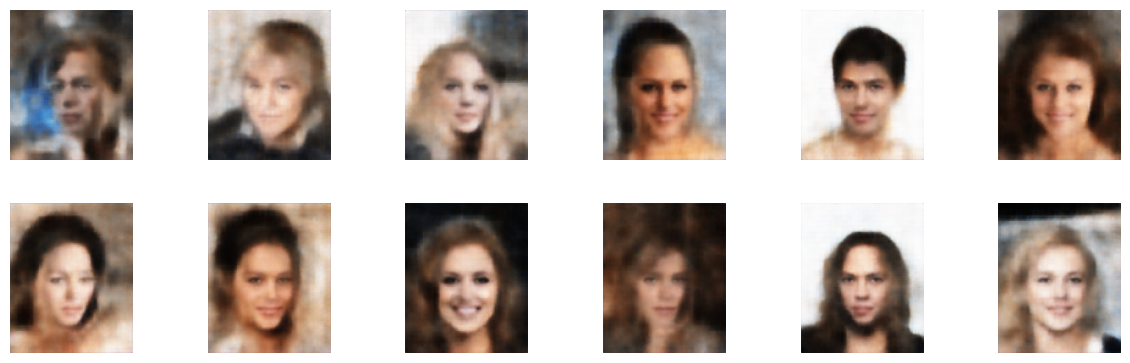

In [36]:
#@title Plot Reconstructions

import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_tensor(tensor):
    """
    Plots images from a 4D tensor (batch, C, W, H) with 3 color channels.

    Args:
    tensor (numpy.ndarray): The 4D tensor to plot, with shape (batch, C, W, H).
    """
    if tensor.shape[1] != 3:
        raise ValueError("Tensor must have 3 channels")

    batch_size = tensor.shape[0]
    rows = (batch_size + 5) // 6  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, 6, figsize=(12, 2 * rows))
    fig.tight_layout(pad=1.0)

    # Flattening the axes array for easy iteration
    axes = axes.ravel()

    for i in range(batch_size):
        # Transpose tensor to shape (W, H, C) for plotting
        img = tensor[i].permute(1, 2, 0)
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis

    # Turn off axes for any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.show()

dataset = FaceDataset('norm_bounding_boxes.csv', 'data')
# model = torch.load("boiNet.pt", map_location=torch.device('cpu'))

img = torch.stack([dataset[i][0] for i in range(12)])
face = torch.stack([dataset[i][1] for i in range(12)])
bbox = torch.stack([dataset[i][2] for i in range(12)])

# fg_rec, bg_rec = model(img, face)
# fg_rec = fg_rec.detach()
# bg_rec = bg_rec.detach()
img = model(img.to(device)).cpu().detach()
plot_tensor(img)
# plot_tensor(fg_rec)
# plot_tensor(bg_rec)

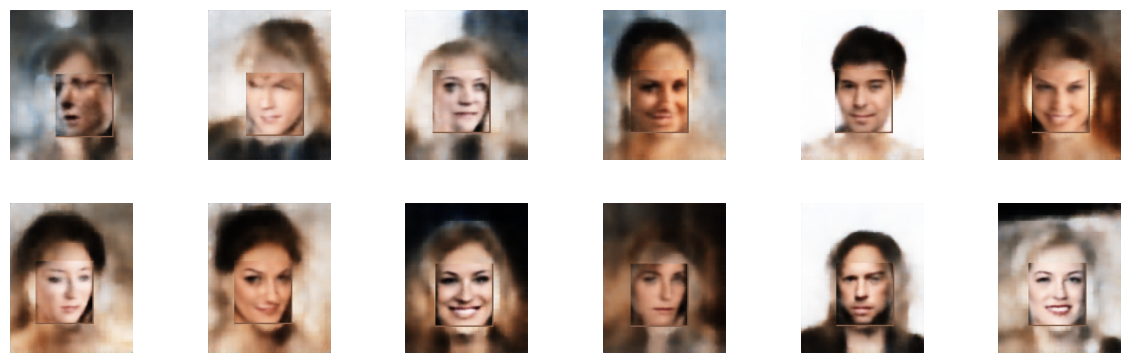

In [ ]:
boxes = create_fg_masks(bbox).repeat(1, 3, 1, 1)
imgs = bg_rec.clone()
for i in range(12):
    imgs[i][boxes[i]] = fg_rec[i].flatten()
plot_tensor(imgs)

# Model Evaluation

In [61]:
#@title Feathering and Stitching
import torch

def create_fg_masks(bboxes, image_height=218, image_width=178, device=None):
    """
    Create foreground masks for a batch of images given their bounding boxes, vectorized version.
    """
    batch_size = bboxes.size(0)
    # Create coordinate grids
    x_coords = torch.arange(image_width, device=device).repeat(image_height, 1).unsqueeze(0).repeat(batch_size, 1, 1)
    y_coords = torch.arange(image_height, device=device).repeat(image_width, 1).t().unsqueeze(0).repeat(batch_size, 1, 1)

    # Get bbox coordinates and expand dimensions for broadcasting
    lefts = bboxes[:, 0].unsqueeze(1).unsqueeze(2)
    tops = bboxes[:, 1].unsqueeze(1).unsqueeze(2)
    rights = bboxes[:, 2].unsqueeze(1).unsqueeze(2)
    bottoms = bboxes[:, 3].unsqueeze(1).unsqueeze(2)

    # Create masks using logical operations
    masks = (x_coords >= lefts) & (x_coords < rights) & (y_coords >= tops) & (y_coords < bottoms)
    masks = masks.float().unsqueeze(1)  # Convert from bool to float and add channel dimension

    return masks >= 1


def linear_feather_mask(size, feather_size, device=None):
    """Create a rectangular feather mask which fades in from all sides. FG = 1, BG = 0."""

    # Vertical and horizontal gradients
    h, w = size
    u = torch.linspace(0, 1, steps=w, device=device).unsqueeze(0).repeat(h, 1)
    v = torch.linspace(0, 1, steps=h, device=device).unsqueeze(1).repeat(1, w)

    # Combine them to get a gradient that fades in from all sides
    mask = torch.min(u, torch.min(1-u, torch.min(v, 1-v)))
    mask = torch.clamp(mask * max(w, h) / feather_size, 0, 1)

    return mask


def stitch(fg, bg, bboxes, feather_size=3, device=None):
    """Given batched fg, bg, and bboxes coordinates, stitch fg and bg
    together with feathering.
    """
    N, _, H, W = bg.shape

    mask_fg = linear_feather_mask(fg.shape[2:], feather_size, device=device)
    mask_fg = mask_fg.expand((N, 1, fg.shape[2], fg.shape[3]))

    binary_fg_mask = create_fg_masks(bboxes, H, W, device=device)
    mask_bg = torch.ones((N, 1, H, W), device=device)
    mask_bg[binary_fg_mask] = (1 - mask_fg).flatten()

    rec = bg * mask_bg
    rec[binary_fg_mask.expand_as(bg)] += (fg * mask_fg).flatten()

    return rec

In [63]:
#@title Dataset initialization

from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
import torch
import torchvision
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

class FaceDataset(Dataset):
    def __init__(self, df_path, image_dir, return_im_num=False):
        self.dataframe = pd.read_csv(df_path)
        self.image_dir = image_dir

        # Transformations
        self.transform = transforms.Compose([
            transforms.Resize((92, 84)),
            transforms.ToTensor()
        ])

        self.return_im_num = return_im_num

    def __len__(self):
        return len(self.dataframe)

    def extract_im_num(self, filename: str):
        format_i = filename.find('.jpg')

        if format_i == -1:
            raise ValueError("Unexpected dataset file format")

        return torch.tensor(int(filename[:format_i]), dtype=torch.int)

    def __getitem__(self, idx):
        filename = self.dataframe.iloc[idx, 0]
        img_name = os.path.join(self.image_dir, filename)

        image = Image.open(img_name)
        bbox = self.dataframe.iloc[idx, 1:5].values
        face_crop = image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))

        if self.transform:
            face_crop = self.transform(face_crop)

        to_tensor = transforms.ToTensor()
        image = to_tensor(image)

        bbox = np.array(bbox, dtype=int)

        if self.return_im_num:
            return self.extract_im_num(filename), image, face_crop, torch.tensor(bbox)

        return image, face_crop, torch.tensor(bbox)

In [180]:
#@title Model loading, resetting the compressed folder (comment out !rm -rf compressed if first time running)
model = torch.load('l1,msssim,baseline.pt').to(device)
!rm -rf compressed
output_folder = '/compressed/'
os.makedirs(output_folder, exist_ok=True)

In [ ]:
#@title Producing, saving feathered stiches to compressed
dataset = FaceDataset('norm_bounding_boxes_fixed.csv', 'data', return_im_num=True)
loader = DataLoader(dataset, batch_size=25)

for j, (img_num, images, faces, bboxs) in enumerate(loader):
    if j > 100:
        break
    images, faces = images.to(device), faces.to(device)
    filenames = []

    fg_masks = create_fg_masks(bboxs).to(device)
    fg_output, bg_output = model(images * (~fg_masks), faces)

    rec = stitch(fg_output, bg_output, bboxs.to(device), feather_size=10, device=device)

    # Save images
    for i in range(img_num.shape[0]):
        torchvision.utils.save_image(rec[i], os.path.join(output_folder, f'{img_num[i]}.png'))

In [64]:
#@title Model evaluation code V1 (for dual autoencoders)
#@markdown Note that PSNR metric is bugged, and we ended up manually calculating it based on the L2 loss as 20 * log_10(1 / L2) in the report

lpips_alex = LPIPS(net='alex').to(device)
# lpips_squeeze = LPIPS(net='squeeze').to(device)
# lpips_vgg = LPIPS(net='vgg').to(device)

lpips_alex_loss = lambda x, y: lpips_alex(2 * x - 1, 2 * y - 1)
# lpips_squeeze_loss = lambda x, y: lpips_squeeze(2 * x - 1, 2 * y - 1)
# lpips_vgg_loss = lambda x, y: lpips_vgg(2 * x - 1, 2 * y - 1)

msssim = MS_SSIM(data_range=1, size_average=True, channel=3)
l2 = nn.MSELoss()
l1 = nn.L1Loss()

def evaluate_loss(model: nn.Module, dataloader, amount: int=-1, is_two_autoencoder: bool = True) -> None:
    loss_l2 = 0
    loss_l1 = 0
    loss_alex = 0
    loss_squeeze = 0
    loss_vgg = 0
    loss_msssim = 0
    loss_psnr = 0

    for i, (imgs, faces, bboxes) in enumerate(tqdm(dataloader)):
        if i == amount:
            break

        with torch.no_grad():
            if is_two_autoencoder:
                imgs, faces = imgs.to(device), faces.to(device)

                fg_masks = create_fg_masks(bboxes).to(device)
                fg_output, bg_output = model(imgs * (~fg_masks), faces)

                imgs_reconstruction = stitch(fg_output, bg_output,
                                             bboxes.to(device), feather_size=20, device=device)
            else:
                imgs = imgs.to(device)

                imgs_reconstruction = model(imgs)

            loss_l2 += l2(imgs, imgs_reconstruction)
            loss_l1 += l1(imgs, imgs_reconstruction)
            loss_alex += lpips_alex_loss(imgs, imgs_reconstruction).sum()
            # loss_squeeze += lpips_squeeze_loss(imgs, imgs_reconstruction)
            # loss_vgg += lpips_vgg_loss(imgs, imgs_reconstruction)
            loss_msssim += msssim(imgs, imgs_reconstruction)
            loss_psnr += psnr(imgs, imgs_reconstruction, peak=1)

        del imgs, imgs_reconstruction
        torch.cuda.empty_cache()

    n = max(len(dataloader), amount)
    process = lambda x: round(x.item() / n, 5)

    loss_l2 = process(loss_l2)
    loss_l1 = process(loss_l1)
    loss_alex = process(loss_alex)
    # loss_squeeze = process(torch.mean(loss_squeeze))
    # loss_vgg = process(torch.mean(loss_vgg))
    loss_msssim = process(loss_msssim)
    loss_psnr = process(loss_psnr)

    print(f"MODEL EVALUATION")
    print(f"----------------")
    print(f"{loss_l2}\tL2")
    print(f"{loss_l1}\tL1")
    print(f"{loss_alex}\tLPIPS-Alex")
    # print(f"{loss_squeeze}\tLPIPS-Squeeze")
    # print(f"{loss_vgg}\tLPIPS-VGG")
    print(f"{loss_msssim}\tMS-SSIM")
    print(f"{loss_psnr}\tPSNR")


def evaluate_loss_no_model(dataloader, amount: int=-1) -> None:
    loss_l2 = 0
    loss_l1 = 0
    loss_alex = 0
    # loss_squeeze = 0
    # loss_vgg = 0
    loss_msssim = 0
    loss_psnr = 0

    for i, (imgs, imgs_reconstruction) in enumerate(tqdm(dataloader)):
        if i == amount:
            break

        imgs, imgs_reconstruction = imgs.to(device), imgs_reconstruction.to(device)

        loss_l2 += l2(imgs, imgs_reconstruction)
        loss_l1 += l1(imgs, imgs_reconstruction)
        loss_alex += lpips_alex_loss(imgs, imgs_reconstruction).sum()
        # loss_squeeze += lpips_squeeze_loss(imgs, imgs_reconstruction)
        # loss_vgg += lpips_vgg_loss(imgs, imgs_reconstruction)
        loss_msssim += msssim(imgs, imgs_reconstruction)
        loss_psnr += psnr(imgs, imgs_reconstruction, peak=1)

        del imgs, imgs_reconstruction
        torch.cuda.empty_cache()

    n = max(len(dataloader), amount)
    process = lambda x: round(x.item() / n, 5)

    loss_l2 = process(loss_l2)
    loss_l1 = process(loss_l1)
    loss_alex = process(loss_alex)
    # loss_squeeze = process(torch.mean(loss_squeeze))
    # loss_vgg = process(torch.mean(loss_vgg))
    loss_msssim = process(loss_msssim)
    loss_psnr = process(loss_psnr)

    print(f"MODEL EVALUATION")
    print(f"----------------")
    print(f"{loss_l2}\tL2")
    print(f"{loss_l1}\tL1")
    print(f"{loss_alex}\tLPIPS-Alex")
    # print(f"{loss_squeeze}\tLPIPS-Squeeze")
    # print(f"{loss_vgg}\tLPIPS-VGG")
    print(f"{loss_msssim}\tMS-SSIM")
    print(f"{loss_psnr}\tPSNR")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /content/weights/v0.1/alex.pth


In [148]:
#@title More dataset initializing

class JpgBeforeAfterDataset():
    def __init__(self, before_dir, after_dir):
        # Assume after_dir is a subset of before_dir.
        self.image_names_before = os.listdir(before_dir)
        self.image_names_after = os.listdir(after_dir)
        self.before_dir = before_dir
        self.after_dir = after_dir
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.image_names_after)

    def __getitem__(self, idx):
        before = Image.open(os.path.join(self.before_dir, self.image_names_before[idx]))
        after = Image.open(os.path.join(self.after_dir, self.image_names_after[idx]))

        return self.to_tensor(before), self.to_tensor(after)


if __name__ == "__main__":
    # Load the bounding box data
    df_path = 'norm_bounding_boxes_fixed.csv'

    # Initialize dataset and dataloader
    dataset = FaceDataset(df_path, 'data')
    dataloader = DataLoader(dataset, batch_size=25, shuffle=False)

In [149]:
before_dir = 'data'
after_dir = 'compressed'

dataset = JpgBeforeAfterDataset(before_dir, after_dir)
dataloader = DataLoader(dataset, batch_size=32)

evaluate_loss_no_model(dataloader, amount=-1)

100%|██████████| 79/79 [00:13<00:00,  5.75it/s]

MODEL EVALUATION
----------------
0.15882	L2
0.31321	L1
20.45489	LPIPS-Alex
0.2263	MS-SSIM
8.00563	PSNR


In [38]:
#@title Model Evaluation Code V2 (for baseline models)
imgs, imgs_reconstruction = None, None

def evaluate_loss(model: nn.Module, amount: int=-1) -> None:
    global imgs, imgs_reconstruction
    loss_l2 = 0
    loss_l1 = 0
    loss_alex = 0
    loss_msssim = 0
    loss_psnr = 0

    for i, (imgs, _, _) in enumerate(tqdm(dataloader)):
        if i == amount:
            break
        imgs = imgs.to(device)

        with torch.no_grad():
            imgs_reconstruction = model(imgs)
            loss_l2 += torch.mean((imgs - imgs_reconstruction) ** 2)
            loss_l1 += torch.mean(torch.abs(imgs - imgs_reconstruction))
            loss_alex += torch.mean(lpips_alex_loss(imgs_reconstruction, imgs))
            loss_msssim += msssim(imgs, imgs_reconstruction)
            loss_psnr += psnr(imgs, imgs_reconstruction, peak=1)

        del imgs, imgs_reconstruction
        torch.cuda.empty_cache()

    n = max(len(dataloader), amount)
    process = lambda x: round(x.item() / n, 5)

    loss_l2 = process(loss_l2)
    loss_l1 = process(loss_l1)
    loss_alex = process(loss_alex)
    loss_msssim = process(loss_msssim)
    loss_psnr = process(loss_psnr)

    print(f"MODEL EVALUATION")
    print(f"----------------")
    print(f"{loss_l2}\tL2")
    print(f"{loss_l1}\tL1")
    print(f"{loss_alex}\tLPIPS-Alex")
    print(f"{loss_msssim}\tMS-SSIM")
    print(f"{loss_psnr}\tPSNR")


def plot_examples(model: nn.Module, amount: int=5, offset: int=0) -> None:
    for i, (imgs, _, _) in enumerate(dataloader):
        while i < offset:
            continue
        imgs = imgs.to(device)
        with torch.no_grad():
            imgs_reconstruction = model(imgs)

        fig, ax = plt.subplots(2, amount)
        fig.set_figwidth(30)
        fig.set_figheight(15)

        for k in range(amount):
            ax[0, k].imshow(to_pil_image(imgs[k]))
            ax[1, k].imshow(to_pil_image(imgs_reconstruction[k]))
            ax[0, k].axis('off')
            ax[1, k].axis('off')

        del imgs, imgs_reconstruction
        torch.cuda.empty_cache()
        break


def evaluate_loss_rounding(model: nn.Module, base_model: bool = True, amount: int=-1) -> None:
    loss_l2 = 0
    loss_l1 = 0
    loss_alex = 0
    loss_squeeze = 0
    loss_vgg = 0
    loss_msssim = 0
    loss_psnr = 0

    for i, (imgs, _, _) in enumerate(tqdm(dataloader)):
        if i == amount:
            break
        imgs = imgs.to(device)

        with torch.no_grad():
            if base_model:
                encoded = model.encoder(imgs)
                imgs_reconstruction = model.decoder(torch.round(encoded))
            else:
                raise NotImplementedError()

            loss_l2 += l2(imgs_reconstruction, imgs)
            loss_l1 += l1(imgs_reconstruction, imgs)
            loss_alex += torch.mean(lpips_alex_loss(imgs_reconstruction, imgs))
            loss_msssim += msssim(imgs_reconstruction, imgs)
            loss_psnr += psnr(imgs_reconstruction, imgs, peak=1)

        del imgs, x, r, encoded
        torch.cuda.empty_cache()

    n = max(len(dataloader), amount)
    process = lambda x: round(x.item() / n, 5)

    loss_l2 = process(loss_l2)
    loss_l1 = process(loss_l1)
    loss_alex = process(torch.mean(loss_alex))
    loss_msssim = process(loss_msssim)
    loss_psnr = process(loss_psnr)

    print(f"MODEL EVALUATION")
    print(f"----------------")
    print(f"{loss_l2}\tL2")
    print(f"{loss_l1}\tL1")
    print(f"{loss_alex}\tLPIPS-Alex")
    print(f"{loss_msssim}\tMS-SSIM")
    print(f"{loss_psnr}\tPSNR")


def plot_examples_rounding(model: nn.Module, base_model: bool=True, amount: int=5, offset: int=0) -> None:
    for i, (imgs, _, _) in enumerate(dataloader):
        while i < offset:
            continue
        imgs = imgs.to(device)
        with torch.no_grad():
            if base_model:
                encoded = model.encoder(imgs)
                x = model.decoder(encoded)
                r = model.decoder(torch.round(encoded))
            else:
                raise NotImplementedError()

        fig, ax = plt.subplots(2, amount)
        fig.set_figwidth(30)
        fig.set_figheight(15)

        for k in range(amount):
            with torch.no_grad():
                diff = torch.mean(torch.abs(r[k] - x[k]), dim=0).cpu().detach()
            ax[0, k].imshow(to_pil_image(r[k]))
            ax[1, k].imshow(diff)
            ax[0, k].axis('off')
            ax[1, k].axis('off')

        del imgs, x, r, encoded
        torch.cuda.empty_cache()
        break

def plot_latent_space(model: nn.Module, base_model: bool=True, amount: int=3, offset: int=0, shape: tuple[int, int]=(40, 25)) -> None:
    for i, (imgs, _, _) in enumerate(dataloader):
        while i < offset:
            continue
        imgs = imgs.to(device)
        with torch.no_grad():
            if base_model:
                encoded = model.encoder(imgs)
            else:
                raise NotImplementedError()

        fig, ax = plt.subplots(1, amount)
        fig.set_figwidth(30)
        fig.set_figheight(12)

        for k in range(amount):
            img = ax[k].imshow(encoded[k].cpu().detach().reshape(shape))
            fig.colorbar(img)
            ax[k].axis('off')

        del imgs, encoded
        torch.cuda.empty_cache()
        break

In [42]:
evaluate_loss(torch.load('l1,msssim,baseline,mask.pt'), amount=-1)

100%|██████████| 392/392 [00:34<00:00, 11.31it/s]

MODEL EVALUATION
----------------
0.01094	L2
0.07145	L1
0.41896	LPIPS-Alex
0.81214	MS-SSIM
19.63619	PSNR


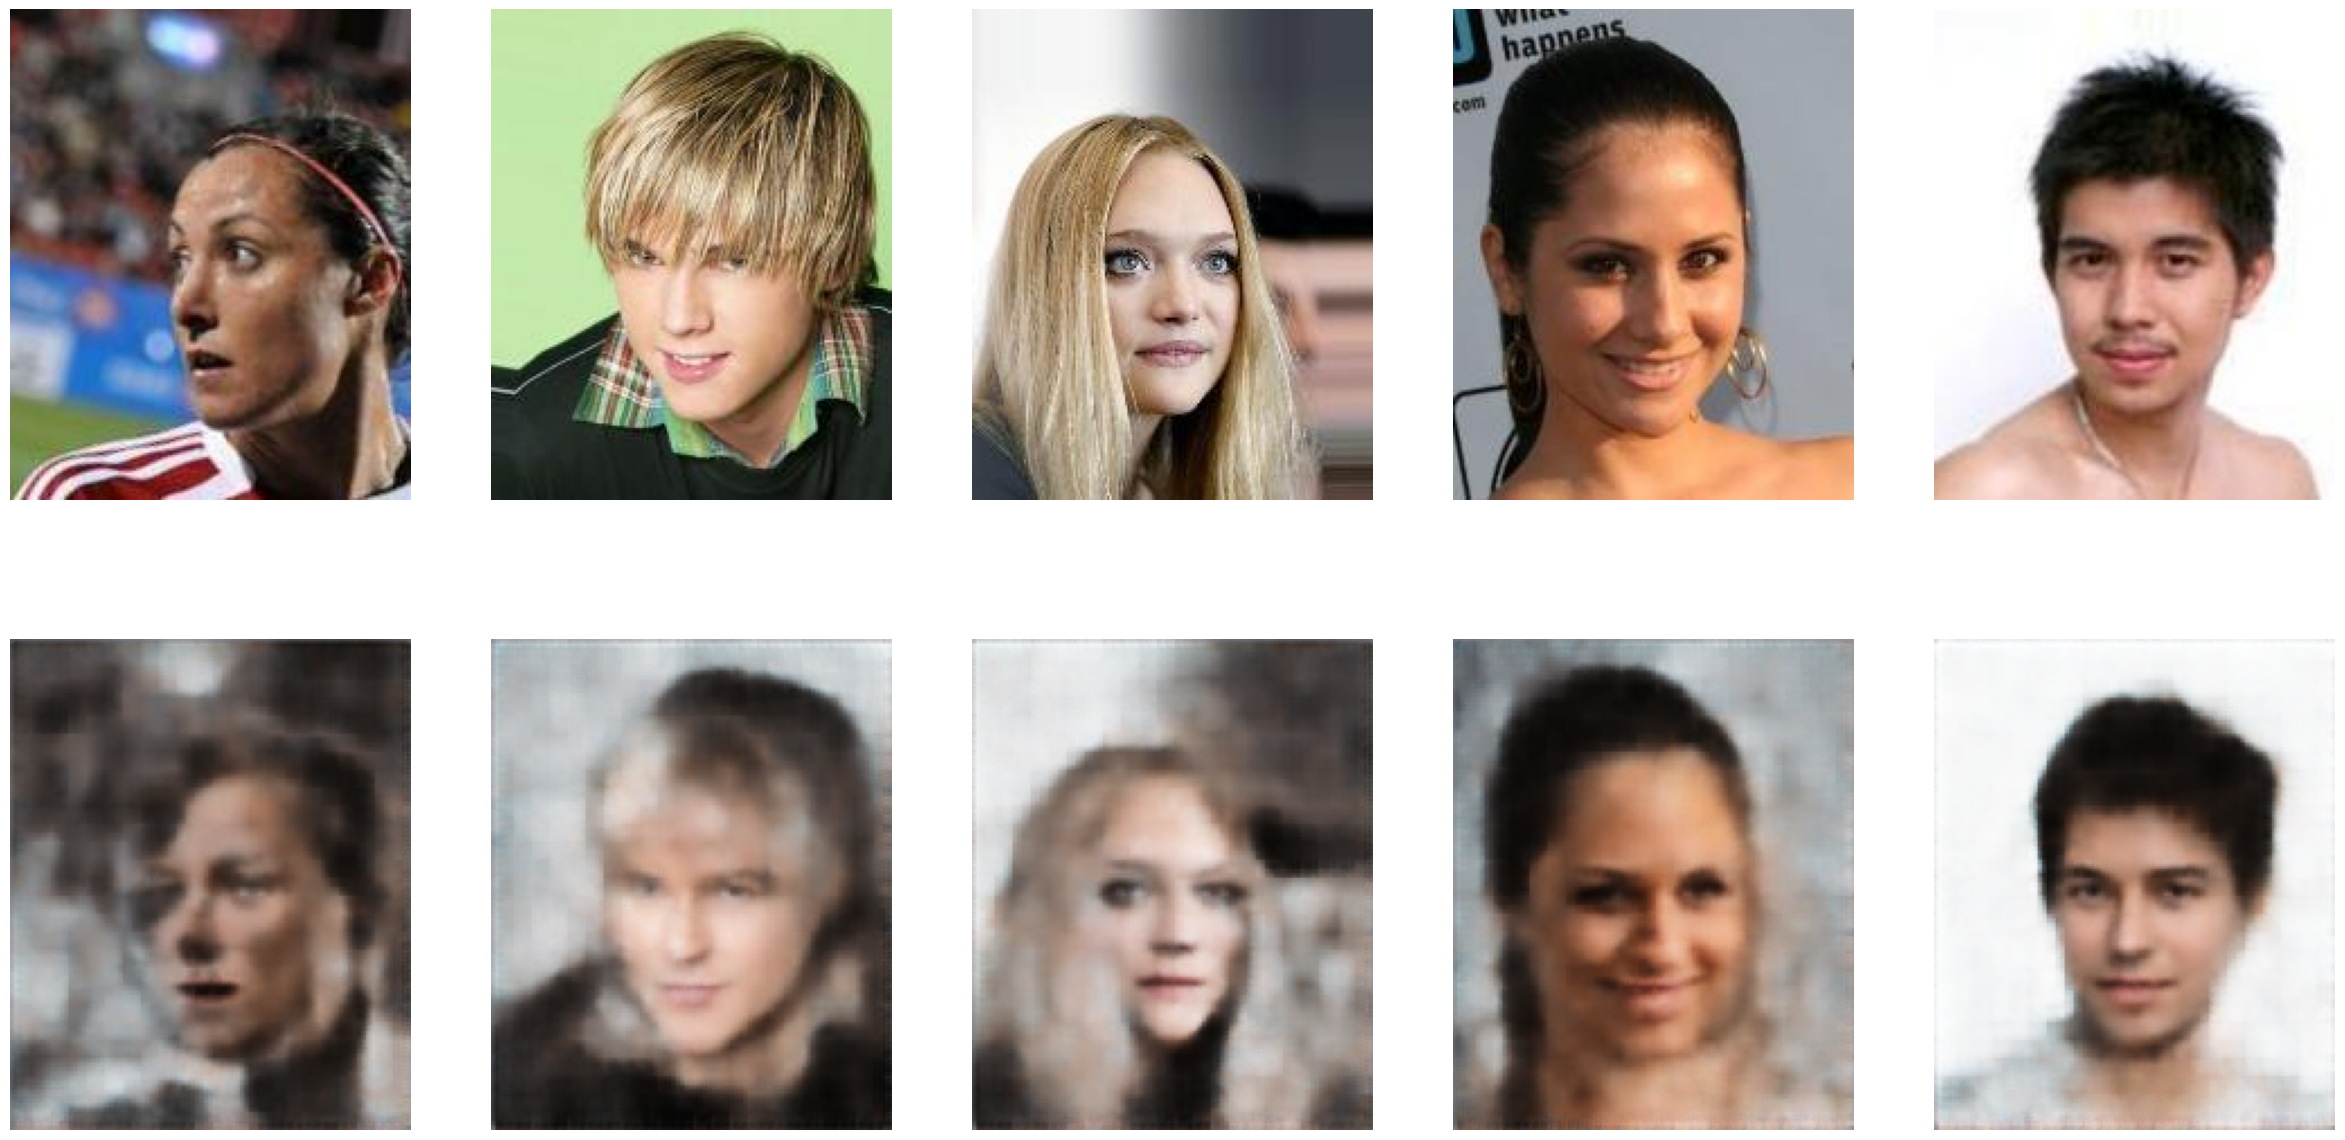

In [ ]:
plot_examples(model)

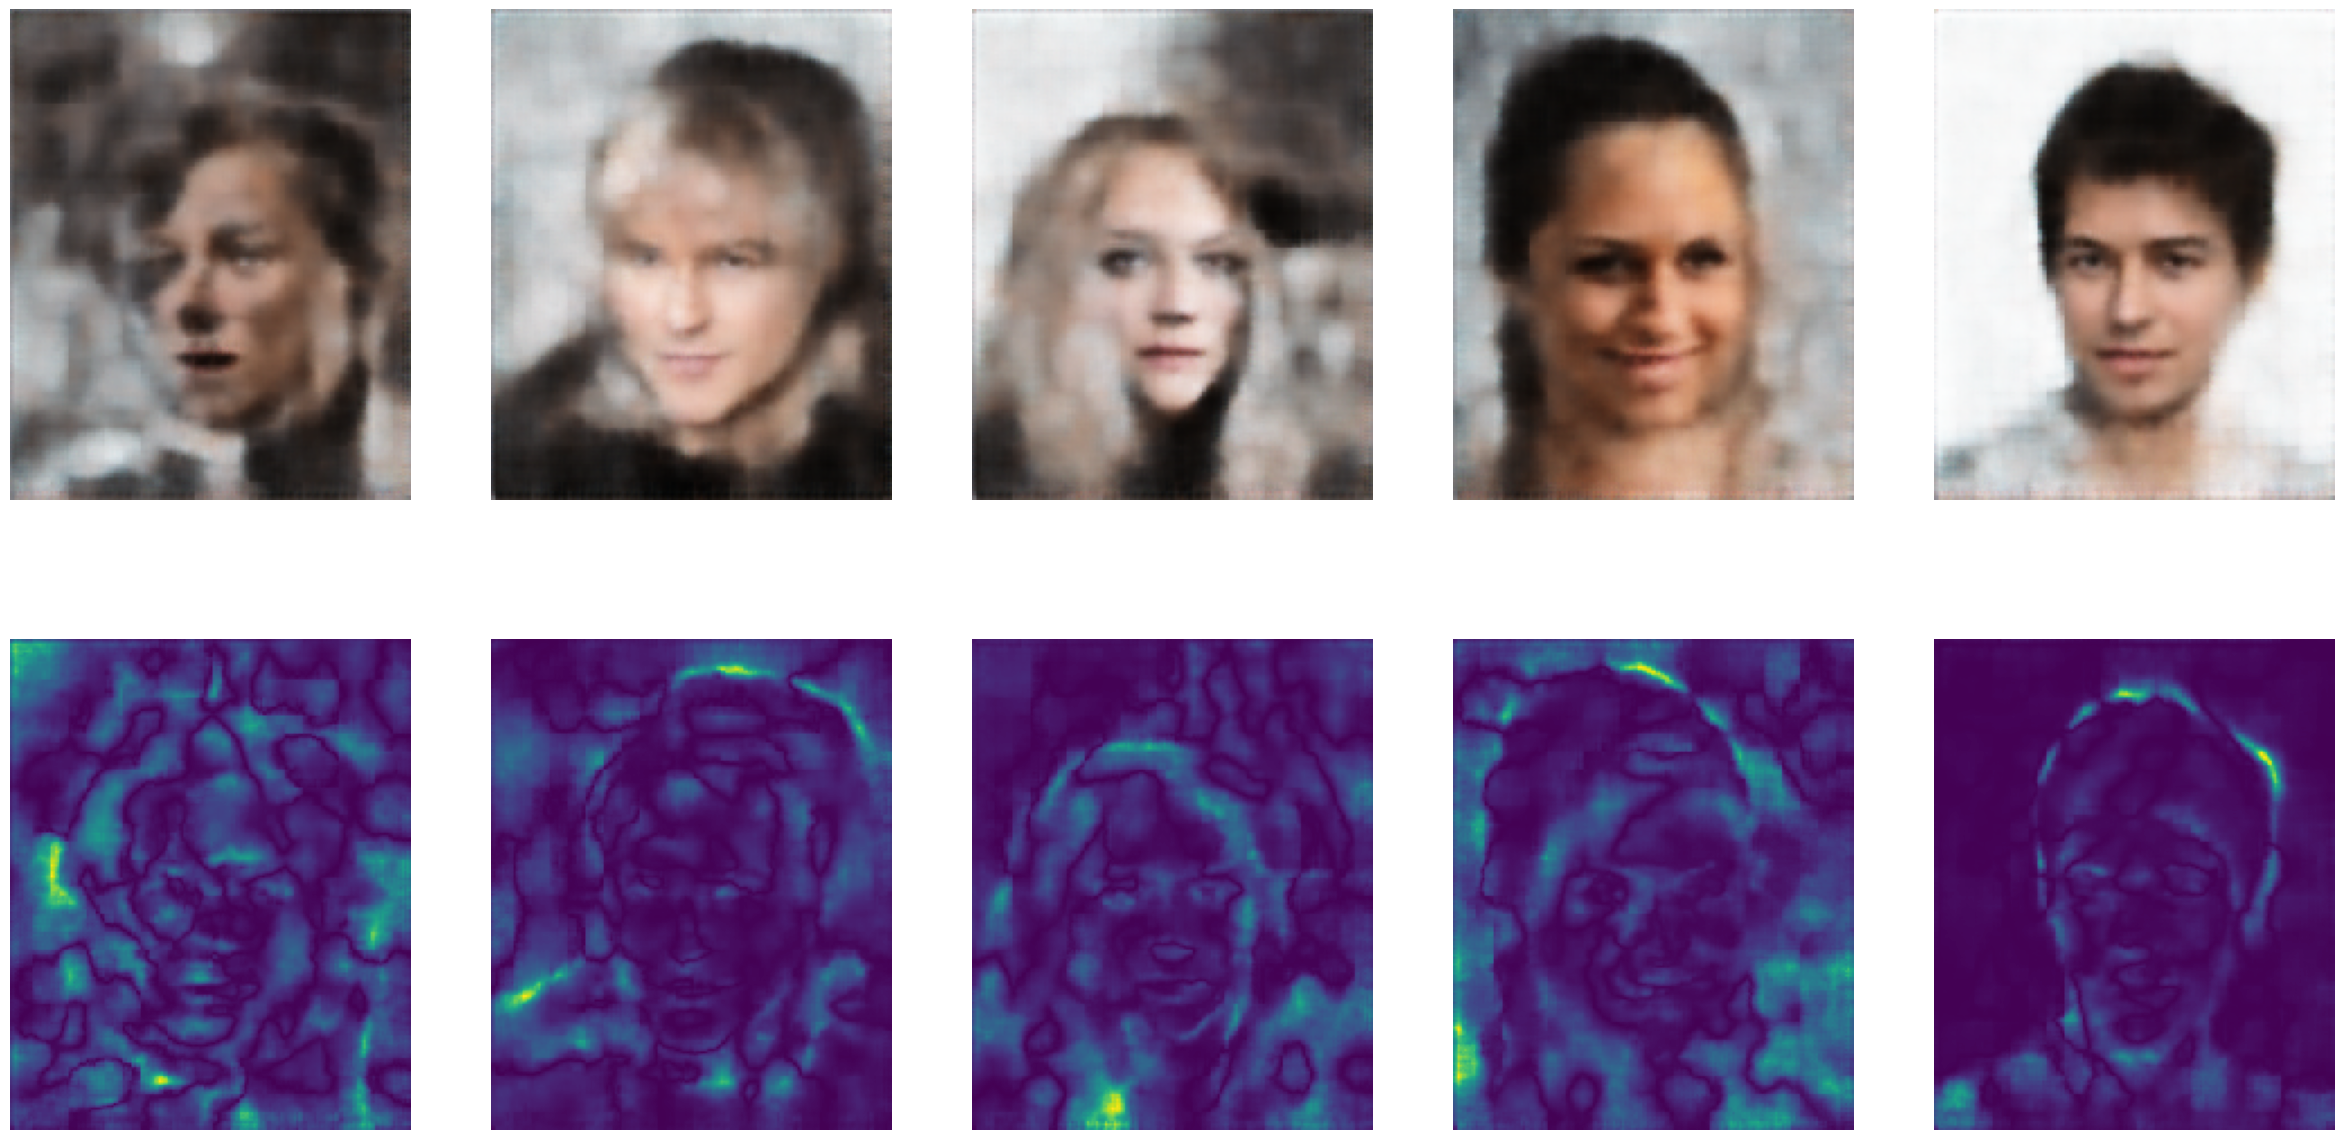

In [ ]:
plot_examples_rounding(model)

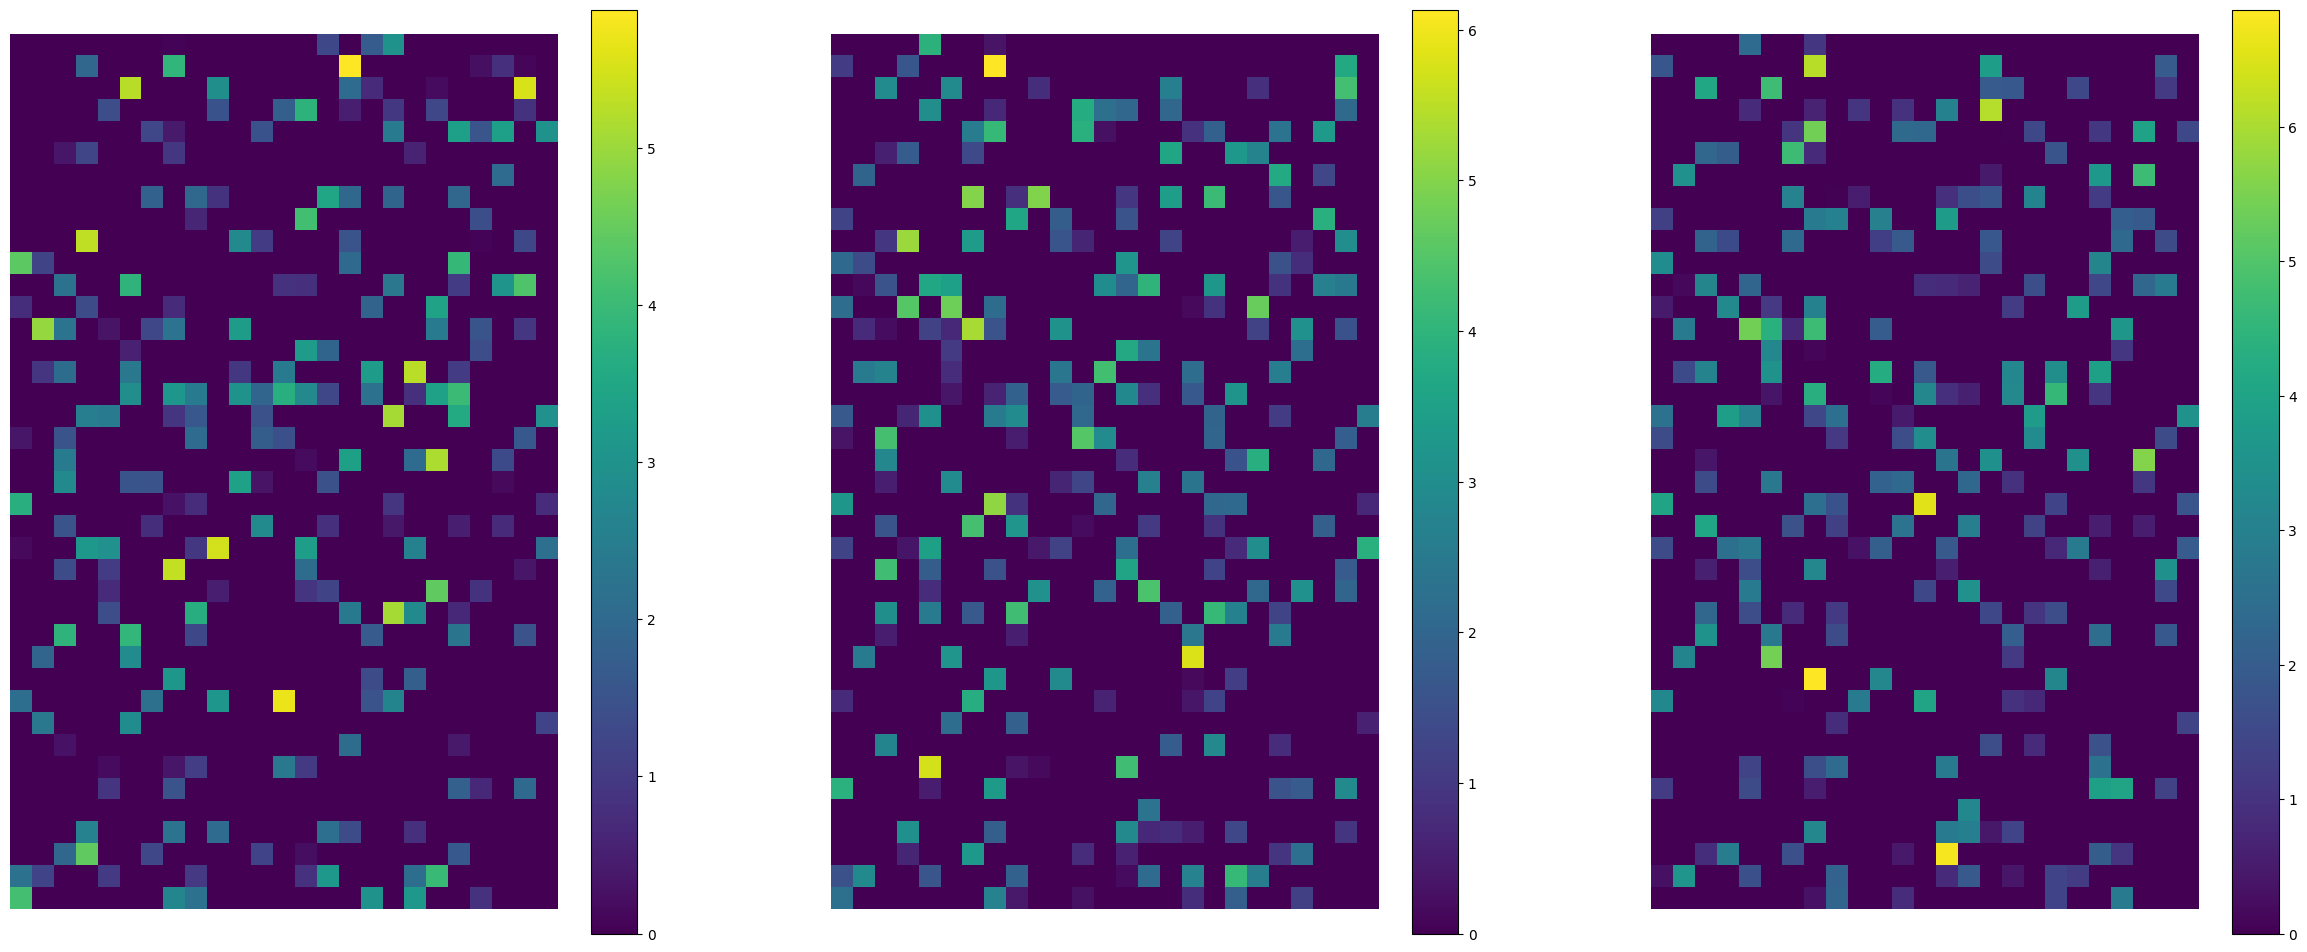

In [ ]:
plot_latent_space(model)